## **Question 3 _ conditional GAN**

### Code description:

The define_discriminator() below implements this update to the discriminator model. The parameterized shape of the input image is also used after the embedding layer to define the number of activations for the fully connected layer to reshape its output. The number of classes in the problem is also parameterized in the function and set.

The define_generator() function below implements this, again parameterizing the number of classes as we did with the discriminator model.

The new GAN model will take a point in latent space as input and a class label and generate a prediction of whether input was real or fake, as before.






In [2]:
!nvidia-smi

Tue Aug  4 15:13:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
%tensorflow_version 1.x
import tensorflow
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K


In [11]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

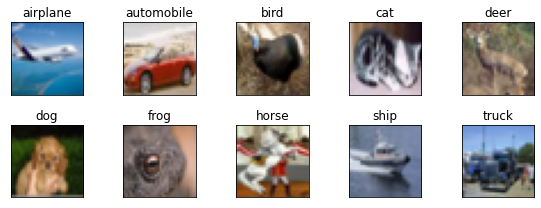

In [12]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [13]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [14]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)
print(X_train[0].shape)


X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)
(32, 32, 3)


generator

In [15]:

# latent space dimension
z = Input(shape=(100,))

# classes
labels = Input(shape=(10,))

# Generator network
merged_layer = Concatenate()([z, labels])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

# # Conv 1: 4x4x256
generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 2: 8x8x128
generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 3: 16x16x64
generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 4: 32x32x3
generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

# generator = Model(inputs=[z, labels], outputs=out_g)
generator = Model(inputs=[z, labels], outputs=generator, name='generator')

Generator model visualization

In [16]:
# prints a summary representation of your model
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 110)          0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         227328      concatenate_2[0][0]      

Discriminator

In [17]:
# input image
img_input = Input(shape=(X_train[0].shape))

# Conv 1: 16x16x64
discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 2:
discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 3: 
discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 4: 
discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# FC
discriminator = Flatten()(discriminator)

# Concatenate 
merged_layer = Concatenate()([discriminator, labels])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, labels], outputs=discriminator, name='discriminator')

Discriminator model visualization

In [18]:
# prints a summary representation of your model
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   4864        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 16, 16, 64)   0           batch_normalization_9[0][0]      
______________________________________________________________________________________

Compile discriminator

In [19]:
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
discriminator.trainable = False

label = Input(shape=(10,), name='label')
z = Input(shape=(100,), name='z')

fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = Model([z, label], validity, name='adversarial')

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [21]:
# prints a summary representation of your model
d_g.summary()

Model: "adversarial"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    4543363     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            5365121     generator[1][0]        

Fit model


epoch = 1/153, d_loss=0.281, g_loss=4.023                                                                                                     


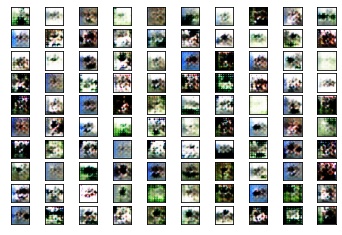

epoch = 2/153, d_loss=0.398, g_loss=4.933                                                                                                     
epoch = 3/153, d_loss=0.350, g_loss=3.072                                                                                                     
epoch = 4/153, d_loss=0.351, g_loss=2.652                                                                                                     
epoch = 5/153, d_loss=0.463, g_loss=5.718                                                                                                     
epoch = 6/153, d_loss=0.513, g_loss=3.409                                                                                                     
epoch = 7/153, d_loss=0.303, g_loss=3.544                                                                                                     
epoch = 8/153, d_loss=0.284, g_loss=2.508                                                                                                     

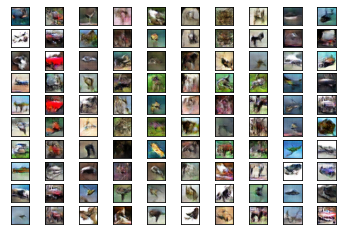

epoch = 12/153, d_loss=0.179, g_loss=2.929                                                                                                     
epoch = 13/153, d_loss=0.363, g_loss=3.411                                                                                                     
epoch = 14/153, d_loss=0.182, g_loss=0.422                                                                                                     
epoch = 15/153, d_loss=0.970, g_loss=0.263                                                                                                     
epoch = 16/153, d_loss=0.329, g_loss=16.678                                                                                                     
epoch = 17/153, d_loss=0.166, g_loss=6.655                                                                                                     
epoch = 18/153, d_loss=0.179, g_loss=4.722                                                                                             

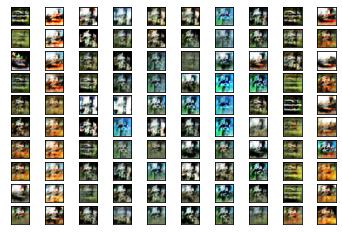

epoch = 22/153, d_loss=0.177, g_loss=0.828                                                                                                     
epoch = 23/153, d_loss=0.173, g_loss=21.073                                                                                                     
epoch = 24/153, d_loss=0.189, g_loss=11.157                                                                                                     
epoch = 25/153, d_loss=0.173, g_loss=7.528                                                                                                     
epoch = 26/153, d_loss=0.168, g_loss=12.455                                                                                                     
epoch = 27/153, d_loss=0.171, g_loss=13.513                                                                                                     
epoch = 28/153, d_loss=0.177, g_loss=7.818                                                                                          

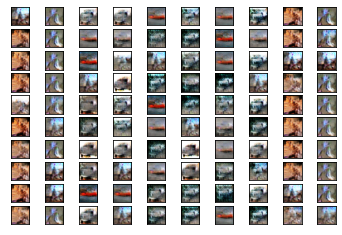

epoch = 32/153, d_loss=0.181, g_loss=9.242                                                                                                     
epoch = 33/153, d_loss=0.179, g_loss=16.378                                                                                                     
epoch = 34/153, d_loss=0.170, g_loss=7.570                                                                                                     
epoch = 35/153, d_loss=0.167, g_loss=6.875                                                                                                     
epoch = 36/153, d_loss=0.172, g_loss=11.155                                                                                                     
epoch = 37/153, d_loss=0.168, g_loss=25.920                                                                                                     
epoch = 38/153, d_loss=0.180, g_loss=5.747                                                                                           

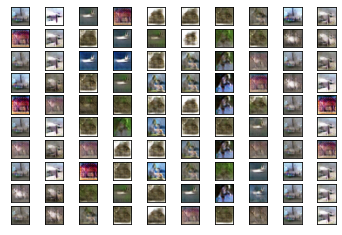

epoch = 42/153, d_loss=0.188, g_loss=7.587                                                                                                     
epoch = 43/153, d_loss=0.231, g_loss=5.221                                                                                                     
epoch = 44/153, d_loss=0.168, g_loss=10.386                                                                                                     
epoch = 45/153, d_loss=0.171, g_loss=8.996                                                                                                     
epoch = 46/153, d_loss=0.167, g_loss=8.363                                                                                                     
epoch = 47/153, d_loss=0.179, g_loss=12.352                                                                                                     
epoch = 48/153, d_loss=0.279, g_loss=3.894                                                                                            

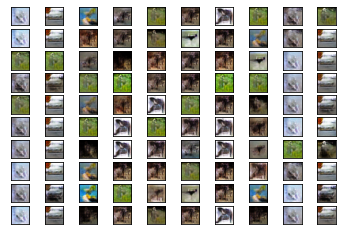

epoch = 52/153, d_loss=0.191, g_loss=8.286                                                                                                     
epoch = 53/153, d_loss=0.562, g_loss=8.252                                                                                                     
epoch = 54/153, d_loss=0.195, g_loss=13.961                                                                                                     
epoch = 55/153, d_loss=0.188, g_loss=4.994                                                                                                     
epoch = 56/153, d_loss=0.168, g_loss=7.747                                                                                                     
epoch = 57/153, d_loss=0.213, g_loss=11.180                                                                                                     
epoch = 58/153, d_loss=0.166, g_loss=16.617                                                                                           

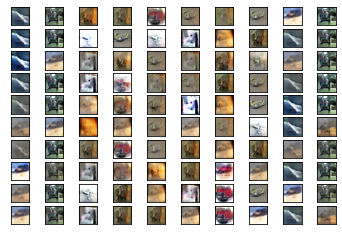

epoch = 62/153, d_loss=0.165, g_loss=4.743                                                                                                     
epoch = 63/153, d_loss=0.169, g_loss=4.844                                                                                                     
epoch = 64/153, d_loss=0.175, g_loss=7.770                                                                                                     
epoch = 65/153, d_loss=0.175, g_loss=7.096                                                                                                     
epoch = 66/153, d_loss=0.171, g_loss=6.084                                                                                                     
epoch = 67/153, d_loss=0.177, g_loss=5.032                                                                                                     
epoch = 68/153, d_loss=0.167, g_loss=8.997                                                                                              

In [22]:
epochs = 153
batch_size = 32
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
      for j in range(10):
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')
        if j==0 :
          a1 = np.copy(x_fake)
        else:
          a1 = np.concatenate((a1, x_fake))
      for k in range(100):
        plt.subplot(10, 10, k + 1, xticks=[], yticks=[])
        plt.imshow(a1[k])
        #plt.title(class_names[k])
        #plt.tight_layout()
      plt.show()

Evaluate model

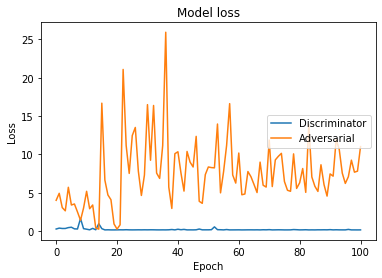

In [26]:
# plotting the metrics
plt.plot(d_loss[:101])
plt.plot(d_g_loss[:101])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()